# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [480]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

import plotly.express as px
import matplotlib.pyplot as plt

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Understanding

Lets look at 3 different datasets.

#### Portfolio dataset

In [396]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [397]:
portfolio.describe()

reward  difficulty   duration
count  10.000000   10.000000  10.000000
mean    4.200000    7.700000   6.500000
std     3.583915    5.831905   2.321398
min     0.000000    0.000000   3.000000
25%     2.000000    5.000000   5.000000
50%     4.000000    8.500000   7.000000
75%     5.000000   10.000000   7.000000
max    10.000000   20.000000  10.000000

In [398]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [399]:
portfolio.shape

(10, 6)

#### Profile dataset

In [400]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [401]:
profile.describe()

age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000

In [402]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [403]:
profile.shape

(17000, 5)

In [404]:
profile[profile['gender'].isnull()].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [405]:
profile[profile['income'].isnull()].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [406]:
profile.duplicated().sum()

0

In [407]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

##### We can say that there is 2175 rows have null values for gender and income columns, and no duplicate rows.

#### Transcript dataset

In [408]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [409]:
transcript.describe()

time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000

In [410]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [411]:
transcript.shape

(306534, 4)

In [412]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [413]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

### Data Cleaning

Lets clean our datasets.

In [414]:
# check the outliers of age column
fig = px.box(profile, y="age")
fig.show()

In [415]:
# let's check the income of age 118

check_age = profile[profile['age']== 118]
check_age.head()

gender  age                                id  became_member_on  income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     NaN
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712     NaN
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804     NaN
6   None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925     NaN
7   None  118  68617ca6246f4fbc85e91a2a49552598          20171002     NaN

In [416]:
check_age.describe()

age  became_member_on  income
count  2175.0      2.175000e+03     0.0
mean    118.0      2.016804e+07     NaN
std       0.0      1.009105e+04     NaN
min     118.0      2.013080e+07     NaN
25%     118.0      2.016070e+07     NaN
50%     118.0      2.017073e+07     NaN
75%     118.0      2.017123e+07     NaN
max     118.0      2.018073e+07     NaN

In [417]:
# As result we found that age 118 is a dummy data. there are 2175 rows in gender and income have no info, so we will drop them. 

profile = profile[profile['age']<118].reset_index(drop=True)

In [418]:
profile.describe()

age  became_member_on         income
count  14825.000000      1.482500e+04   14825.000000
mean      54.393524      2.016689e+07   65404.991568
std       17.383705      1.188565e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       42.000000      2.016052e+07   49000.000000
50%       55.000000      2.017080e+07   64000.000000
75%       66.000000      2.017123e+07   80000.000000
max      101.000000      2.018073e+07  120000.000000

In [419]:
profile.head()

gender  age                                id  became_member_on    income
0      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
1      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
2      M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0
3      M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0
4      M   58  2eeac8d8feae4a8cad5a6af0499a211d          20171111   51000.0

In [420]:
# convert (became_member_on) to date
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [421]:
profile.head()

gender  age                                id became_member_on    income
0      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0
1      F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0
2      M   68  e2127556f4f64592b11af22de27a7932       2018-04-26   70000.0
3      M   65  389bc3fa690240e798340f5a15918d5c       2018-02-09   53000.0
4      M   58  2eeac8d8feae4a8cad5a6af0499a211d       2017-11-11   51000.0

In [422]:
# keep only the year
profile['became_member_on'] = pd.Series([int(str(x)[:4]) for x in profile['became_member_on']])

In [423]:
profile.head()

gender  age                                id  became_member_on    income
0      F   55  0610b486422d4921ae7d2bf64640c50b              2017  112000.0
1      F   75  78afa995795e4d85b5d9ceeca43f5fef              2017  100000.0
2      M   68  e2127556f4f64592b11af22de27a7932              2018   70000.0
3      M   65  389bc3fa690240e798340f5a15918d5c              2018   53000.0
4      M   58  2eeac8d8feae4a8cad5a6af0499a211d              2017   51000.0

In [424]:
# rename columns
profile = profile.rename(columns={'id':'customer_id'})

In [425]:
profile.head()

gender  age                       customer_id  became_member_on    income
0      F   55  0610b486422d4921ae7d2bf64640c50b              2017  112000.0
1      F   75  78afa995795e4d85b5d9ceeca43f5fef              2017  100000.0
2      M   68  e2127556f4f64592b11af22de27a7932              2018   70000.0
3      M   65  389bc3fa690240e798340f5a15918d5c              2018   53000.0
4      M   58  2eeac8d8feae4a8cad5a6af0499a211d              2017   51000.0

In [426]:
# convert day to hour

portfolio['duration']=portfolio['duration'] * 24
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10       168           bogo   
1      10  [web, email, mobile, social]          10       120           bogo   
2       0          [web, email, mobile]           0        96  informational   
3       5          [web, email, mobile]           5       168           bogo   
4       5                  [web, email]          20       240       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [427]:
# rename id column to offer_id
portfolio=portfolio.rename(columns={'id':'offer_id'})

In [428]:
# one hot encoding for channel column
portfolio['email']=portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile']=portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social']=portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio['web']=portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

In [429]:
portfolio.drop(['channels'], axis=1, inplace=True)
portfolio.head()

reward  difficulty  duration     offer_type  \
0      10          10       168           bogo   
1      10          10       120           bogo   
2       0           0        96  informational   
3       5           5       168           bogo   
4       5          20       240       discount   

                           offer_id  email  mobile  social  web  
0  ae264e3637204a6fb9bb56bc8210ddfd      1       1       1    0  
1  4d5c57ea9a6940dd891ad53e9dbe8da0      1       1       1    1  
2  3f207df678b143eea3cee63160fa8bed      1       1       0    1  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9      1       1       0    1  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7      1       0       0    1

In [430]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [431]:
# divide value column into 2 due to different info
transcript['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in transcript.value]
transcript['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in transcript.value]

In [432]:
# rename
transcript=transcript.rename(columns={'person':'customer_id'})

In [433]:
# drop value column
transcript=transcript.drop(columns={'value'})
transcript.head()

customer_id           event  time  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received     0   
1  a03223e636434f42ac4c3df47e8bac43  offer received     0   
2  e2127556f4f64592b11af22de27a7932  offer received     0   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received     0   
4  68617ca6246f4fbc85e91a2a49552598  offer received     0   

                           offer_id  amount  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7     NaN  
2  2906b810c7d4411798c6938adc9daaa5     NaN  
3  fafdcd668e3743c1bb461111dcafc2a4     NaN  
4  4d5c57ea9a6940dd891ad53e9dbe8da0     NaN

In [434]:
portfolio.head()

reward  difficulty  duration     offer_type  \
0      10          10       168           bogo   
1      10          10       120           bogo   
2       0           0        96  informational   
3       5           5       168           bogo   
4       5          20       240       discount   

                           offer_id  email  mobile  social  web  
0  ae264e3637204a6fb9bb56bc8210ddfd      1       1       1    0  
1  4d5c57ea9a6940dd891ad53e9dbe8da0      1       1       1    1  
2  3f207df678b143eea3cee63160fa8bed      1       1       0    1  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9      1       1       0    1  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7      1       0       0    1

In [435]:
profile.head()

gender  age                       customer_id  became_member_on    income
0      F   55  0610b486422d4921ae7d2bf64640c50b              2017  112000.0
1      F   75  78afa995795e4d85b5d9ceeca43f5fef              2017  100000.0
2      M   68  e2127556f4f64592b11af22de27a7932              2018   70000.0
3      M   65  389bc3fa690240e798340f5a15918d5c              2018   53000.0
4      M   58  2eeac8d8feae4a8cad5a6af0499a211d              2017   51000.0

In [436]:
# Merge 1 (merge profile with transcript)
df = pd.merge(profile,transcript, on='customer_id')

In [437]:
df.head()

gender  age                       customer_id  became_member_on    income  \
0      F   55  0610b486422d4921ae7d2bf64640c50b              2017  112000.0   
1      F   55  0610b486422d4921ae7d2bf64640c50b              2017  112000.0   
2      F   55  0610b486422d4921ae7d2bf64640c50b              2017  112000.0   
3      F   55  0610b486422d4921ae7d2bf64640c50b              2017  112000.0   
4      F   55  0610b486422d4921ae7d2bf64640c50b              2017  112000.0   

            event  time                          offer_id  amount  
0     transaction    18                              None   21.51  
1     transaction   144                              None   32.28  
2  offer received   408  9b98b8c7a33c4b65b9aebfe6a799e6d9     NaN  
3  offer received   504  3f207df678b143eea3cee63160fa8bed     NaN  
4     transaction   528                              None   23.22

In [464]:
# Renumber customer_id
customer_id_dict = df['customer_id'].unique()
customer_id_dict = pd.Series(customer_id_dict).to_dict()
customer_id_dict = dict([(v, k) for k, v in customer_id_dict.items()]) 

In [440]:
# Renumber offer_id
offer_id_dict = df['offer_id'].unique()
offer_id_dict = pd.Series(offer_id_dict).to_dict()
offer_id_dict = dict([(v, k) for k, v in offer_id_dict.items()]) 

In [441]:
offer_id_dict

{None: 0,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 1,
 '3f207df678b143eea3cee63160fa8bed': 2,
 '5a8bc65990b245e5a138643cd4eb9837': 3,
 'ae264e3637204a6fb9bb56bc8210ddfd': 4,
 'f19421c1d4aa40978ebb69ca19b0e20d': 5,
 '2906b810c7d4411798c6938adc9daaa5': 6,
 'fafdcd668e3743c1bb461111dcafc2a4': 7,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 8,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 9,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 10}

In [442]:
# Mapping the new ids to original df
df['customer_id'] = df['customer_id'].map(customer_id_dict)
df['offer_id'] = df['offer_id'].map(offer_id_dict)

In [443]:
# Mapping the new offer id to original portfolio dataset for future merge
portfolio['offer_id'] = portfolio['offer_id'].map(offer_id_dict)

In [444]:
df.head()

gender  age  customer_id  became_member_on    income           event  time  \
0      F   55            0              2017  112000.0     transaction    18   
1      F   55            0              2017  112000.0     transaction   144   
2      F   55            0              2017  112000.0  offer received   408   
3      F   55            0              2017  112000.0  offer received   504   
4      F   55            0              2017  112000.0     transaction   528   

   offer_id  amount  
0         0   21.51  
1         0   32.28  
2         1     NaN  
3         2     NaN  
4         0   23.22

In [445]:
portfolio.head()

reward  difficulty  duration     offer_type  offer_id  email  mobile  \
0      10          10       168           bogo         4      1       1   
1      10          10       120           bogo        10      1       1   
2       0           0        96  informational         2      1       1   
3       5           5       168           bogo         1      1       1   
4       5          20       240       discount         9      1       0   

   social  web  
0       1    0  
1       1    1  
2       0    1  
3       0    1  
4       0    1

In [448]:
# df1 shows us the only offer's transactions
df1 = pd.merge(df, portfolio, on='offer_id')
df1 = df1.drop(columns={'amount'})

In [449]:
df1.head()

gender  age  customer_id  became_member_on    income            event  time  \
0      F   55            0              2017  112000.0   offer received   408   
1      F   55            0              2017  112000.0  offer completed   528   
2      F   75            1              2017  100000.0   offer received     0   
3      F   75            1              2017  100000.0     offer viewed     6   
4      F   75            1              2017  100000.0  offer completed   132   

   offer_id  reward  difficulty  duration offer_type  email  mobile  social  \
0         1       5           5       168       bogo      1       1       0   
1         1       5           5       168       bogo      1       1       0   
2         1       5           5       168       bogo      1       1       0   
3         1       5           5       168       bogo      1       1       0   
4         1       5           5       168       bogo      1       1       0   

   web  
0    1  
1    1  
2    1  
3    1  
4    1

In [455]:
df1.shape

(148805, 16)

In [456]:
#check events
df1['event'].unique()

array(['offer received', 'offer completed', 'offer viewed'], dtype=object)

In [457]:
# df1 shows us the only offer's transactions
df1.describe()

age    customer_id  became_member_on         income  \
count  148805.000000  148805.000000     148805.000000  148805.000000   
mean       54.779282    7408.517308       2016.576365   66414.119149   
std        17.193533    4278.063634          1.186534   21496.947967   
min        18.000000       0.000000       2013.000000   30000.000000   
25%        43.000000    3705.000000       2016.000000   51000.000000   
50%        56.000000    7400.000000       2017.000000   65000.000000   
75%        67.000000   11110.000000       2017.000000   81000.000000   
max       101.000000   14824.000000       2018.000000  120000.000000   

                time       offer_id         reward     difficulty  \
count  148805.000000  148805.000000  148805.000000  148805.000000   
mean      354.570223       5.706703       4.442445       7.890561   
std       198.311301       2.796607       3.372362       5.041335   
min         0.000000       1.000000       0.000000       0.000000   
25%       168.000000       4.000000       2.000000       5.000000   
50%       408.000000       6.000000       5.000000      10.000000   
75%       510.000000       8.000000       5.000000      10.000000   
max       714.000000      10.000000      10.000000      20.000000   

            duration     email         mobile         social            web  
count  148805.000000  148805.0  148805.000000  148805.000000  148805.000000  
mean      159.004980       1.0       0.917160       0.658311       0.806747  
std        51.192852       0.0       0.275641       0.474277       0.394851  
min        72.000000       1.0       0.000000       0.000000       0.000000  
25%       120.000000       1.0       1.000000       0.000000       1.000000  
50%       168.000000       1.0       1.000000       1.000000       1.000000  
75%       168.000000       1.0       1.000000       1.000000       1.000000  
max       240.000000       1.0       1.000000       1.000000       1.000000

In [450]:
df2=df.drop(columns={'offer_id'})

In [451]:
# df3 shows us w/o any offers transactions so only transaction events
df3=df2.dropna(subset=['amount'])

In [452]:
df3.head()

gender  age  customer_id  became_member_on    income        event  time  \
0       F   55            0              2017  112000.0  transaction    18   
1       F   55            0              2017  112000.0  transaction   144   
4       F   55            0              2017  112000.0  transaction   528   
8       F   75            1              2017  100000.0  transaction   132   
10      F   75            1              2017  100000.0  transaction   144   

    amount  
0    21.51  
1    32.28  
4    23.22  
8    19.89  
10   17.78

In [459]:
# df3 shows us w/o any offers transactions
df3.describe()

age    customer_id  became_member_on         income  \
count  123957.000000  123957.000000     123957.000000  123957.000000   
mean       52.713965    7416.438079       2016.314666   61843.510250   
std        17.906667    4277.226631          1.241192   20661.890394   
min        18.000000       0.000000       2013.000000   30000.000000   
25%        39.000000    3721.000000       2016.000000   46000.000000   
50%        54.000000    7424.000000       2017.000000   60000.000000   
75%        65.000000   11105.000000       2017.000000   74000.000000   
max       101.000000   14824.000000       2018.000000  120000.000000   

                time         amount  
count  123957.000000  123957.000000  
mean      381.278201      13.996325  
std       201.829085      31.749420  
min         0.000000       0.050000  
25%       210.000000       3.660000  
50%       402.000000      10.800000  
75%       552.000000      19.130000  
max       714.000000    1062.280000

In [460]:
# df shows us whole transactions
df.describe()

age    customer_id  became_member_on         income  \
count  272762.000000  272762.000000     272762.000000  272762.000000   
mean       53.840696    7412.116911       2016.457435   64337.000755   
std        17.551337    4277.677254          1.218663   21243.762941   
min        18.000000       0.000000       2013.000000   30000.000000   
25%        41.000000    3712.000000       2016.000000   48000.000000   
50%        55.000000    7409.000000       2017.000000   62000.000000   
75%        66.000000   11109.000000       2017.000000   78000.000000   
max       101.000000   14824.000000       2018.000000  120000.000000   

                time       offer_id         amount  
count  272762.000000  272762.000000  123957.000000  
mean      366.707694       3.113286      13.996325  
std       200.359087       3.512949      31.749420  
min         0.000000       0.000000       0.050000  
25%       186.000000       0.000000       3.660000  
50%       408.000000       1.000000      10.800000  
75%       528.000000       6.000000      19.130000  
max       714.000000      10.000000    1062.280000

## Additional data cleaning process to be added for modelling.
#### we need to convert some data to metrics

In [465]:
df1_model = df1.copy(deep=True)

In [466]:
df1_model["gender"][df1_model["gender"] == "M"] = 1
df1_model["gender"][df1_model["gender"] == "F"] = -1
df1_model["gender"][df1_model["gender"] == "O"] = 0

C:\Users\midos\AppData\Local\Temp\ipykernel_15816\3955041835.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\midos\AppData\Local\Temp\ipykernel_15816\3955041835.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\midos\AppData\Local\Temp\ipykernel_15816\3955041835.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [467]:
df1_model.head()

gender  age  customer_id  became_member_on    income            event  time  \
0     -1   55            0              2017  112000.0   offer received   408   
1     -1   55            0              2017  112000.0  offer completed   528   
2     -1   75            1              2017  100000.0   offer received     0   
3     -1   75            1              2017  100000.0     offer viewed     6   
4     -1   75            1              2017  100000.0  offer completed   132   

   offer_id  reward  difficulty  duration offer_type  email  mobile  social  \
0         1       5           5       168       bogo      1       1       0   
1         1       5           5       168       bogo      1       1       0   
2         1       5           5       168       bogo      1       1       0   
3         1       5           5       168       bogo      1       1       0   
4         1       5           5       168       bogo      1       1       0   

   web  
0    1  
1    1  
2    1  
3    1  
4    1

In [468]:
df1_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   gender            148805 non-null  object 
 1   age               148805 non-null  int64  
 2   customer_id       148805 non-null  int64  
 3   became_member_on  148805 non-null  int64  
 4   income            148805 non-null  float64
 5   event             148805 non-null  object 
 6   time              148805 non-null  int64  
 7   offer_id          148805 non-null  int64  
 8   reward            148805 non-null  int64  
 9   difficulty        148805 non-null  int64  
 10  duration          148805 non-null  int64  
 11  offer_type        148805 non-null  object 
 12  email             148805 non-null  int64  
 13  mobile            148805 non-null  int64  
 14  social            148805 non-null  int64  
 15  web               148805 non-null  int64  
dtypes: float64(1), int64

In [470]:
offer_type_dict = df1_model['offer_type'].unique()

In [471]:
offer_type_dict

array(['bogo', 'informational', 'discount'], dtype=object)

In [472]:
df1_model["offer_type"][df1_model["offer_type"] == "bogo"] = 1
df1_model["offer_type"][df1_model["offer_type"] == "informational"] = -1
df1_model["offer_type"][df1_model["offer_type"] == "discount"] = 0

C:\Users\midos\AppData\Local\Temp\ipykernel_15816\3941135635.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\midos\AppData\Local\Temp\ipykernel_15816\3941135635.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\midos\AppData\Local\Temp\ipykernel_15816\3941135635.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [473]:
#encode 'event' data to numerical values
df1_model['event'] = df1_model['event'].map({'offer received':0, 'offer viewed':1, 'offer completed':2})

In [474]:
df1_model.head()

gender  age  customer_id  became_member_on    income  event  time  offer_id  \
0     -1   55            0              2017  112000.0      0   408         1   
1     -1   55            0              2017  112000.0      2   528         1   
2     -1   75            1              2017  100000.0      0     0         1   
3     -1   75            1              2017  100000.0      1     6         1   
4     -1   75            1              2017  100000.0      2   132         1   

   reward  difficulty  duration offer_type  email  mobile  social  web  
0       5           5       168          1      1       1       0    1  
1       5           5       168          1      1       1       0    1  
2       5           5       168          1      1       1       0    1  
3       5           5       168          1      1       1       0    1  
4       5           5       168          1      1       1       0    1

In [475]:
df1_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   gender            148805 non-null  object 
 1   age               148805 non-null  int64  
 2   customer_id       148805 non-null  int64  
 3   became_member_on  148805 non-null  int64  
 4   income            148805 non-null  float64
 5   event             148805 non-null  int64  
 6   time              148805 non-null  int64  
 7   offer_id          148805 non-null  int64  
 8   reward            148805 non-null  int64  
 9   difficulty        148805 non-null  int64  
 10  duration          148805 non-null  int64  
 11  offer_type        148805 non-null  object 
 12  email             148805 non-null  int64  
 13  mobile            148805 non-null  int64  
 14  social            148805 non-null  int64  
 15  web               148805 non-null  int64  
dtypes: float64(1), int64

In [476]:
df1_model = df1_model.drop(columns = ["customer_id","email","mobile","social","web"])
df1_model.head()

gender  age  became_member_on    income  event  time  offer_id  reward  \
0     -1   55              2017  112000.0      0   408         1       5   
1     -1   55              2017  112000.0      2   528         1       5   
2     -1   75              2017  100000.0      0     0         1       5   
3     -1   75              2017  100000.0      1     6         1       5   
4     -1   75              2017  100000.0      2   132         1       5   

   difficulty  duration offer_type  
0           5       168          1  
1           5       168          1  
2           5       168          1  
3           5       168          1  
4           5       168          1

In [477]:
df1.head()

gender  age  customer_id  became_member_on    income            event  time  \
0      F   55            0              2017  112000.0   offer received   408   
1      F   55            0              2017  112000.0  offer completed   528   
2      F   75            1              2017  100000.0   offer received     0   
3      F   75            1              2017  100000.0     offer viewed     6   
4      F   75            1              2017  100000.0  offer completed   132   

   offer_id  reward  difficulty  duration offer_type  email  mobile  social  \
0         1       5           5       168       bogo      1       1       0   
1         1       5           5       168       bogo      1       1       0   
2         1       5           5       168       bogo      1       1       0   
3         1       5           5       168       bogo      1       1       0   
4         1       5           5       168       bogo      1       1       0   

   web  
0    1  
1    1  
2    1  
3    1  
4    1

## Now let's check the chrachterestics similarity between df1 and df3

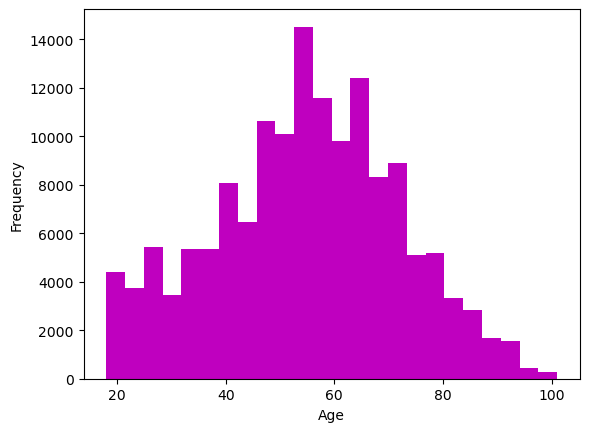

In [554]:
plt.ylabel("Frequency")
plt.xlabel("Age")
plt.hist(df1['age'], color = "m", bins=24);

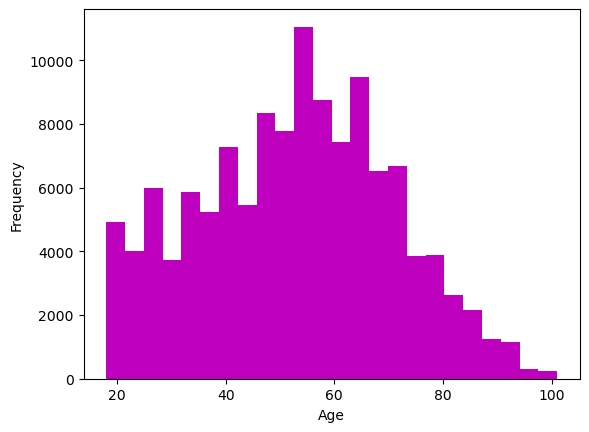

In [553]:
plt.ylabel("Frequency")
plt.xlabel("Age")
plt.hist(df3['age'], color = "m", bins=24);

#### We can see that age distribution is same for df1 and df3 datasets.

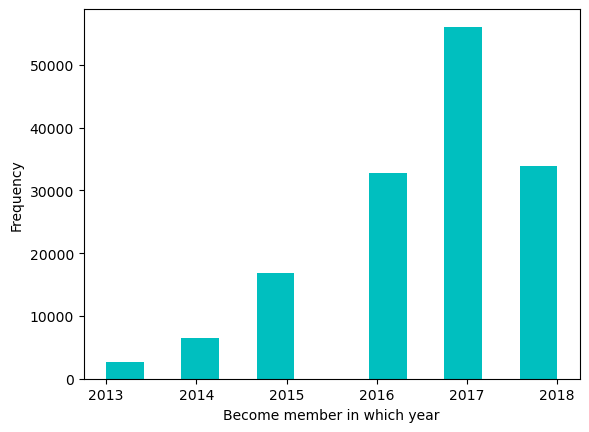

In [552]:
plt.ylabel("Frequency")
plt.xlabel("Become member in which year")
plt.hist(df1['became_member_on'], color = "c", bins=12);

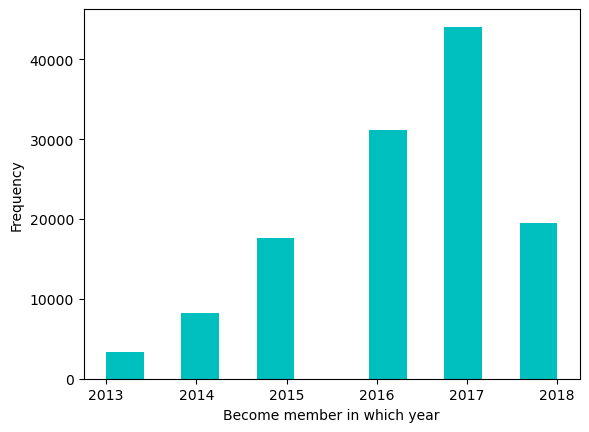

In [551]:
plt.ylabel("Frequency")
plt.xlabel("Become member in which year")
plt.hist(df3['became_member_on'], color = "c", bins=12);

#### We can see that year distribution is same for df1 and df3 datasets.

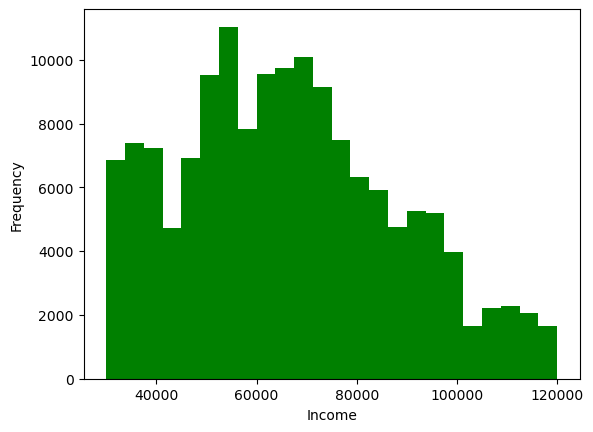

In [550]:
plt.ylabel("Frequency")
plt.xlabel("Income")
plt.hist(df1['income'], color = "g", bins=24);

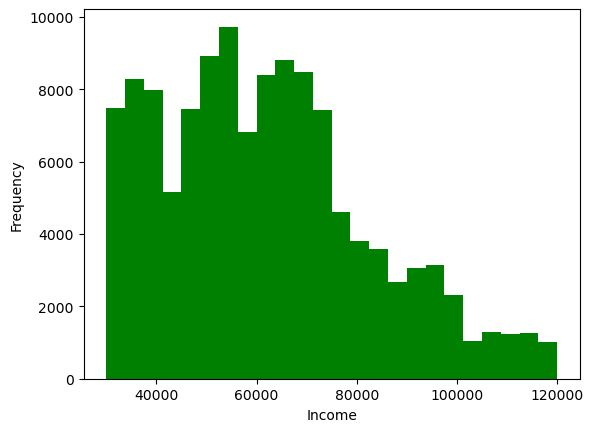

In [549]:
plt.ylabel("Frequency")
plt.xlabel("Income")
plt.hist(df3['income'], color = "g", bins=24);

#### We can notice that income distribution are quit different, specially higher than 75k, it mean that Starbucks has more target for customers who have income between 75k and 100k.

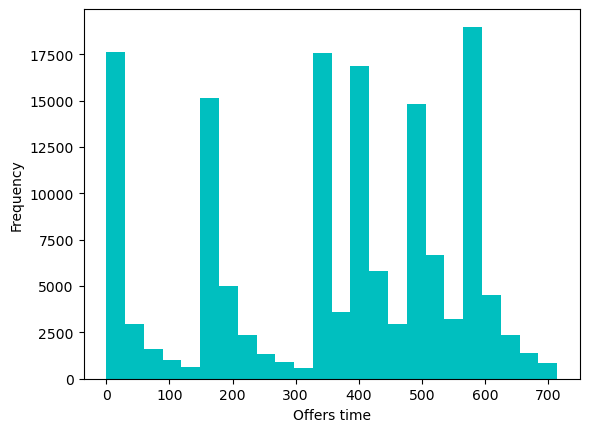

In [560]:
plt.ylabel("Frequency")
plt.xlabel("Offers time")
plt.hist(df1['time'], color = "c", bins=24);

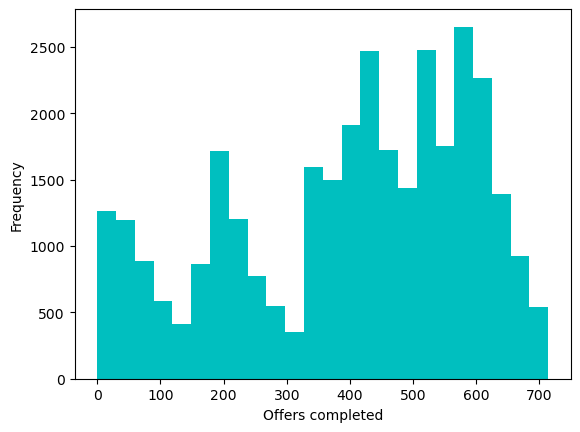

In [561]:
plt.ylabel("Frequency")
plt.xlabel("Offers completed")
plt.hist(df1[df1['event']=="offer completed"]['time'], color = "c", bins=24);

#### After checking both of above figures, we can notice that Starbucks are not sending offers everyday, it usually decrease after second offer which meand, offers are going to decrease when customers not continuing accepting offers

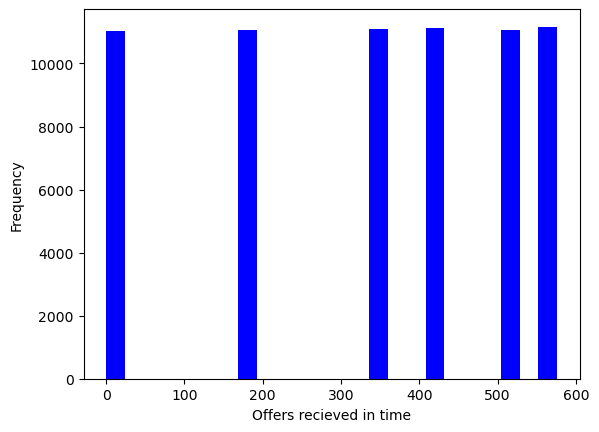

In [565]:
plt.ylabel("Frequency")
plt.xlabel("Offers recieved in time")
plt.hist(df1[df1['event']=="offer received"]['time'], color = "b", bins=24);

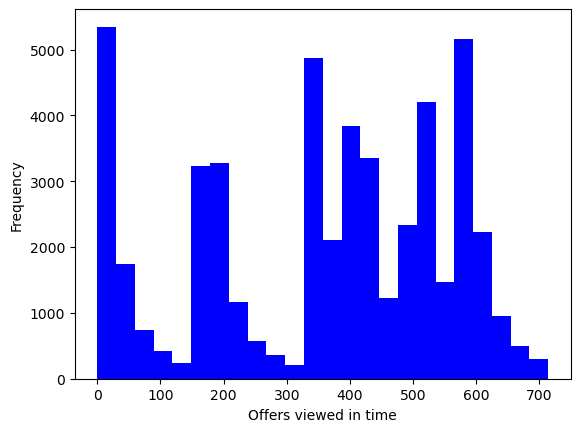

In [566]:
plt.ylabel("Frequency")
plt.xlabel("Offers viewed in time")
plt.hist(df1[df1['event']=="offer viewed"]['time'], color = "b", bins=24);

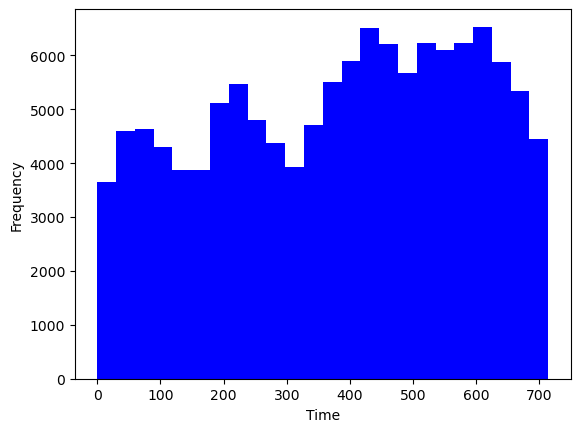

In [567]:
plt.ylabel("Frequency")
plt.xlabel("Time")
plt.hist(df3['time'], color = "b", bins=24);

#### We can notice that transactions w/o offers has increased with the increased frequency of offers

In [573]:
px.histogram(df1, x="offer_type", color="gender",barmode='group')

In [578]:
px.histogram(df3, x="gender", color="gender",barmode='group')

#### As we can notice that; men get more offers.